# Training PGGANs

- [EstimatorBase](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html?highlight=estimatorBase)
- [Sagemaker Tensorflow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html)
- [Inputs](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html)
- [Amazon SageMaker, 배치 변환 기능 및 TensorFlow 컨테이너를 위한 파이프 입력 모드 추가](https://aws.amazon.com/ko/blogs/korea/amazon-sagemaker-adds-batch-transform-feature-and-pipe-input-mode-for-tensorflow-containers/)
- [sagemaker-tensorflow-extensions](https://github.com/aws/sagemaker-tensorflow-extensions)

In [34]:
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.estimator import Framework
from sagemaker import get_execution_role
from sagemaker.session import s3_input
import boto3
import os 

In [48]:
BUCKET_NAME = "sagemaker-jhgan-workspace" # 결과를 저장할 버킷
JOB_NAME = "pggan-LiTS-train-8GPUs"
S3_OUTPUT_LOCATION=f's3://{BUCKET_NAME}'
DOCKER_IMAGE_URI = "349048005035.dkr.ecr.us-east-2.amazonaws.com/pggan:1.15.3-gpu-py3"
VOLUME_SIZE = 200
INSTANCE_COUNT = 1
INSTANCE_TYPE = "ml.p2.8xlarge"
FRAMEWORK_VERSION = "1.15.3"
PY_VERSION = "py3"
MAX_TRAINING_TIME = 86400  * 3
print(f"S3 Output Path: {S3_OUTPUT_LOCATION}")

S3 Output Path: s3://sagemaker-jhgan-workspace


In [49]:
estimator = TensorFlow(
    entry_point = "train.py",
    image_name = DOCKER_IMAGE_URI,
    role = get_execution_role(),
    output_path=S3_OUTPUT_LOCATION,
    train_instance_count=INSTANCE_COUNT,
    train_instance_type=INSTANCE_TYPE,
    train_volume_size=VOLUME_SIZE,
    framework_version=FRAMEWORK_VERSION,
    py_version=PY_VERSION,
    source_dir = "./",
    train_max_run = MAX_TRAINING_TIME
)

In [ ]:
estimator.fit(job_name=JOB_NAME)

INFO:sagemaker:Creating training-job with name: pggan-LiTS-train-8GPUs


2020-07-27 03:23:06 Starting - Starting the training job...
2020-07-27 03:23:08 Starting - Launching requested ML instances.........
2020-07-27 03:24:41 Starting - Preparing the instances for training......
2020-07-27 03:26:01 Downloading - Downloading input data...
2020-07-27 03:26:08 Training - Downloading the training image............
2020-07-27 03:28:17 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-07-27 03:28:21,900 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-27 03:28:28,606 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.tra

# 코드 실험

## 1. 데이터셋 체크

`tfrecords` 파일들은 각각 $2^2$부터 $2^9$ 해상도를 가져야 한다.

> The datasets are represented by directories containing the same image data in several resolutions to enable efficient streaming. There is a separate *.tfrecords file for each resolution, and if the dataset contains labels, they are stored in a separate file as well:

In [ ]:
# Parse individual image from a tfrecords file.
def parse_tfrecord_tf(record):
    features = tf.parse_single_example(record, features={
        'shape': tf.FixedLenFeature([3], tf.int64),
        'data': tf.FixedLenFeature([], tf.string)})
    data = tf.decode_raw(features['data'], tf.int16) # uint8 > int16
    return tf.reshape(data, features['shape'])

def parse_tfrecord_np(record):
    ex = tf.train.Example()
    ex.ParseFromString(record)
    shape = ex.features.feature['shape'].int64_list.value
    data = ex.features.feature['data'].bytes_list.value[0]
    return np.fromstring(data, np.int16).reshape(shape) # uint8 > int16

In [ ]:
prefix = "s3://sagemaker-jhgan-workspace/LiTS-tfrecords/"
tfr_files = [prefix + f"processed_data-r0{i}.tfrecords" for i in range(2, 10)]

tfr_shapes = []
for tfr_file in tfr_files:
    tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
    for record in tf.python_io.tf_record_iterator(tfr_file, tfr_opt):
        shape = parse_tfrecord_np(record).shape
        tfr_shapes.append(parse_tfrecord_np(record).shape)
        print(shape)
        break

## 2. 모델 훈련

In [ ]:
!python train.py

## 3. 스냅샷 체크

### 3.1. 모델 다운로드

In [12]:
import boto3
import pickle
import tensorflow as tf
tf.python.deprecation._PRINT_DEPRECATION_WARNINGS = False

from train import *
import dataset
import config
import numpy as np
import misc

s3 = boto3.client('s3')
with open('model/model.tar.gz', 'wb') as f:
    s3.download_fileobj(BUCKET_NAME, "pggan-LiTS-train-multi-gpu/pggan-LiTS-train-multi-gpu/output/model.tar.gz", f)

!tar -xvf model/model.tar.gz -C model/

### 3.2. 결과 확인

In [2]:
def setup_snapshot_image_grid(G, training_set,
    size    = '1080p',      # '1080p' = to be viewed on 1080p display, '4k' = to be viewed on 4k display.
    layout  = 'random'):    # 'random' = grid contents are selected randomly, 'row_per_class' = each row corresponds to one class label.

    # Select size.
    gw = 1; gh = 1
    if size == '1080p':
        gw = np.clip(1920 // G.output_shape[3], 3, 32)
        gh = np.clip(1080 // G.output_shape[2], 2, 32)
    if size == '4k':
        gw = np.clip(3840 // G.output_shape[3], 7, 32)
        gh = np.clip(2160 // G.output_shape[2], 4, 32)

    # Fill in reals and labels.
    reals = np.zeros([gw * gh] + training_set.shape, dtype=training_set.dtype)
    labels = np.zeros([gw * gh, training_set.label_size], dtype=training_set.label_dtype)
    for idx in range(gw * gh):
        x = idx % gw; y = idx // gw
        while True:
            real, label = training_set.get_minibatch_np(1)
            if layout == 'row_per_class' and training_set.label_size > 0:
                if label[0, y % training_set.label_size] == 0.0:
                    continue
            reals[idx] = real[0]
            labels[idx] = label[0]
            break
            
    # Generate latents.
    latents = misc.random_latents(gw * gh, G)
    return (gw, gh), reals, labels, latents

In [17]:
with tf.Session() as sess:
    training_set = dataset.load_dataset(data_dir="s3://sagemaker-jhgan-workspace", verbose=True, tfrecord_dir=".")
    with open("model/000-pgan-LiTS-preset-v2-8gpus-fp32/network-snapshot-001467.pkl", 'rb') as file:
        G, D, Gs = pickle.load(file)
    gw = 1; gh = 1
    size    = '1080p',      # '1080p' = to be viewed on 1080p display, '4k' = to be viewed on 4k display.
    layout  = 'random'
    if size == '1080p':
        gw = np.clip(1920 // G.output_shape[3], 3, 32)
        gh = np.clip(1080 // G.output_shape[2], 2, 32)
    if size == '4k':
        gw = np.clip(3840 // G.output_shape[3], 7, 32)
        gh = np.clip(2160 // G.output_shape[2], 4, 32)
    latents = misc.random_latents(gw * gh, G)
    labels = np.zeros([gw * gh, training_set.label_size], dtype=training_set.label_dtype)
    grid_fakes = Gs.run(latents, labels, minibatch_size=2)

Streaming data using dataset.TFRecordDataset...
s3://sagemaker-jhgan-workspace/.
Dataset shape = [1, 512, 512]
Dynamic range = [0, 255]
Label size    = 0


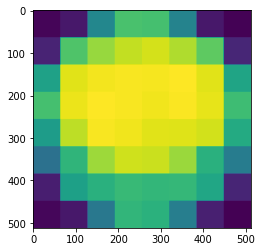

In [27]:
import matplotlib.pyplot as plt
for img in grid_fakes:
    plt.imshow(np.squeeze(img))